In order to download only a subset of the COCO dataset we need to:

1- Download and extract the annotation files

2- Filter the annotations to identify images containing our target categories

3- Download only a limited number of images per category to the "data" folder

4- Move the data folder to your HPC

In [7]:
import os
import json
import random
import requests
import fiftyone as fo
from pycocotools.coco import COCO
from tqdm import tqdm

# URLs for COCO annotation files
ANNOTATION_URLS = {
    'train': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
    'val': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
    'test': 'http://images.cocodataset.org/annotations/image_info_test2017.zip'
}

# URLs for image files
IMAGE_URLS = {
    'train': 'http://images.cocodataset.org/zips/train2017.zip',
    'val': 'http://images.cocodataset.org/zips/val2017.zip',
    'test': 'http://images.cocodataset.org/zips/test2017.zip'
}

# Categories we want to download (category IDs 84, 31, 52)
CATEGORIES_TO_KEEP = [84, 16, 13, 24]
#[book, bird, stop sign, zebra] -->look up in classes.txt
# Maximum images per category (set to None for unlimited)
MAX_IMAGES_PER_CATEGORY = 700  # Change this number as needed
MIN_AREA_MASK=200
VAL_TO_TRAIN_RATIO=0.1#0.3 --> not possible to get more because in COCO 2017 there is only 5000validation images(there is 118,000 training iamges tho) - 0.1*700 = 70 images per class. THere is 80 classes. 80*70 = 5600 images. We assume even distribution of images per class.

def download_file(url, target_path):
    """Download a file if it doesn't exist"""
    if os.path.exists(target_path):
        print(f"File already exists: {target_path}")
        return
    
    print(f"Downloading {url} to {target_path}")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(target_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

def download_and_extract_annotations(split):
    """Download and extract annotation files for a specific split"""
    import zipfile
    
    # Create directories
    os.makedirs('annotations', exist_ok=True)
    
    # Download annotations
    zip_path = f'annotations_{split}2017.zip'
    download_file(ANNOTATION_URLS[split], zip_path)
    
    # Extract annotations
    if not os.path.exists(f'annotations/instances_{split}2017.json'):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')
    
    # Remove zip file to save space
    if os.path.exists(zip_path):
        os.remove(zip_path)
        
    return f'annotations/instances_{split}2017.json'

def get_filtered_image_ids(annotation_file, categories_to_keep, min_area=655, max_per_category=None):
    """Get list of image IDs that contain the specified categories with a maximum per category"""
    coco = COCO(annotation_file)
    image_ids_by_category = {}  # To track image IDs per category
    final_image_ids = set()  # To track final selected image IDs
    
    random.seed(42)
    
    for cat_id in categories_to_keep:
        cat_info = coco.loadCats(cat_id)[0]
        print(f"Finding images with category {cat_id} ({cat_info['name']})")
        
        ann_ids = coco.getAnnIds(catIds=[cat_id], iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        valid_anns = [ann for ann in anns if ann['area'] >= min_area]
        img_ids = list(set([ann['image_id'] for ann in valid_anns]))
        
        # Shuffle the image IDs to get a random selection
        random.shuffle(img_ids)
        
        # Apply max_per_category limit if specified
        if max_per_category is not None and len(img_ids) > max_per_category:
            print(f"Limiting category {cat_id} ({cat_info['name']}) to {max_per_category} images")
            img_ids = img_ids[:max_per_category]
            
        image_ids_by_category[cat_id] = img_ids
        final_image_ids.update(img_ids)
    
    # Convert to list before returning
    final_image_ids = list(final_image_ids)
    
    # Print statistics
    print("\nCategory statistics:")
    for cat_id in categories_to_keep:
        cat_info = coco.loadCats(cat_id)[0]
        print(f"- {cat_info['name']}: {len(image_ids_by_category[cat_id])} images")
    print(f"\nTotal unique images selected: {len(final_image_ids)}")
    
    return final_image_ids, coco

def download_specific_images(image_ids, coco, split, output_dir):
    """Download only the specific images by ID"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Get base URL for images
    base_url = f"http://images.cocodataset.org/train2017/" if split == "train" else "http://images.cocodataset.org/val2017/"
    
    for img_id in tqdm(image_ids, desc=f"Downloading {split} images"):
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]
        url = base_url + file_name
        
        # Create subdirectories if needed
        os.makedirs(os.path.join(output_dir, os.path.dirname(file_name)), exist_ok=True)
        
        # Download image
        target_path = os.path.join(output_dir, file_name)
        if not os.path.exists(target_path):
            try:
                download_file(url, target_path)
            except Exception as e:
                print(f"Error downloading {url}: {e}")


In [ ]:

# Process training data
print("Processing training data...")
train_ann_file = download_and_extract_annotations('train')
train_image_ids, train_coco = get_filtered_image_ids(train_ann_file, CATEGORIES_TO_KEEP, max_per_category=MAX_IMAGES_PER_CATEGORY)
download_specific_images(train_image_ids, train_coco, 'train', 'data/train')

# Process validation data
print("Processing validation data...")
val_ann_file = download_and_extract_annotations('val')
val_image_ids, val_coco = get_filtered_image_ids(val_ann_file, CATEGORIES_TO_KEEP, max_per_category=int(VAL_TO_TRAIN_RATIO*MAX_IMAGES_PER_CATEGORY))
download_specific_images(val_image_ids, val_coco, 'val', 'data/validation')

# Save the configuration for future use
config = {
    "train_image_dir": "data/train",
    "val_image_dir": "data/validation",
    "train_annotation_file": "data/labels/labels_train.json",
    "val_annotation_file": "data/labels/labels_val.json",
    "categories": CATEGORIES_TO_KEEP,
    "max_images_per_category": MAX_IMAGES_PER_CATEGORY
}

# Create labels directory if it doesn't exist
os.makedirs("data/labels", exist_ok=True)

# Also save filtered annotations for compatibility with other code
def save_filtered_annotations(source_ann_file, image_ids, output_file):
    """Save a filtered version of annotations containing only the selected images"""
    with open(source_ann_file, 'r') as f:
        annotations = json.load(f)
    
    # Filter images
    annotations['images'] = [img for img in annotations['images'] if img['id'] in image_ids]
    
    # Filter annotations
    image_id_set = set(image_ids)
    annotations['annotations'] = [ann for ann in annotations['annotations'] 
                                if ann['image_id'] in image_id_set and 
                                ann['category_id'] in CATEGORIES_TO_KEEP and
                                ann['area'] >= MIN_AREA_MASK]
    
    with open(output_file, 'w') as f:
        json.dump(annotations, f)
    
    print(f"Saved filtered annotations to {output_file}")

# Save filtered annotations
save_filtered_annotations(train_ann_file, train_image_ids, 'data/labels/labels_train.json')
save_filtered_annotations(val_ann_file, val_image_ids, 'data/labels/labels_val.json')

with open("dataset_download_config.json", "w") as f:
    json.dump(config, f)

print("Configuration saved to dataset_config.json")

In [8]:
import json
import os
import numpy as np
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image
import os
import numpy as np
import cv2  # OpenCV needed for polygon drawing
from pycocotools import mask as coco_mask
from matplotlib import pyplot as plt
import shutil

config = json.load(open("dataset_download_config.json"))

In [9]:
class CocoSegmentationDatasetMRCNN(Dataset):
    def __init__(self, image_dir, seg_annotation_file, categories_to_keep=[1], min_area_threshold=655, output_dir=None):
        self.image_dir = image_dir
        self.coco_seg = COCO(seg_annotation_file)
        self.min_area_threshold = min_area_threshold
        self.categories_to_keep = categories_to_keep
        self.output_dir = output_dir
        
        # Filter images to keep only those containing objects from specified categories
        self.image_ids = []
        for cat_id in self.categories_to_keep:
            ann_ids = self.coco_seg.getAnnIds(catIds=[cat_id], iscrowd=False)
            anns = self.coco_seg.loadAnns(ann_ids)
            valid_anns = [ann for ann in anns if ann['area'] >= self.min_area_threshold]
            img_ids = list(set([ann['image_id'] for ann in valid_anns]))
            self.image_ids.extend(img_ids)
        
        # Remove duplicates
        self.image_ids = list(set(self.image_ids))
        print(f"Dataset contains {len(self.image_ids)} images with categories {categories_to_keep}")
        
        # For visualization, create a category mapping
        self.category_map = {}
        for cat_id in self.categories_to_keep:
            cat_info = self.coco_seg.loadCats(cat_id)[0]
            self.category_map[cat_id] = cat_info['name']
        
        # Copy images to output directory if specified
        if output_dir:
            self.copy_images_to_output_dir()

    def copy_images_to_output_dir(self):
        """Copy filtered images to the output directory"""
        if not self.output_dir:
            return
            
        # Create output directory
        os.makedirs(self.output_dir, exist_ok=True)
        
        print(f"Copying {len(self.image_ids)} images to {self.output_dir}...")
        copied_count = 0
        
        for img_id in self.image_ids:
            # Get image info
            img_info = self.coco_seg.loadImgs(img_id)[0]
            
            # Source and destination paths
            src_path = os.path.join(self.image_dir, img_info["file_name"])
            dst_path = os.path.join(self.output_dir, img_info["file_name"])
            
            # Copy image if source exists
            if os.path.exists(src_path):
                os.makedirs(os.path.dirname(dst_path), exist_ok=True)
                shutil.copy(src_path, dst_path)
                copied_count += 1
            else:
                print(f"Warning: Could not find {src_path}")
        
        print(f"Copied {copied_count} images to {self.output_dir}")
    

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        # Load image
        image_info = self.coco_seg.loadImgs(image_id)[0]
        image_path = os.path.join(self.image_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")
        
        # Convert to tensor
        image = transforms.ToTensor()(image)
        
        # Load annotations
        ann_ids = self.coco_seg.getAnnIds(imgIds=image_id, catIds=self.categories_to_keep, iscrowd=False)
        anns = self.coco_seg.loadAnns(ann_ids)
        
        # Initialize target dictionary
        target = {}
        boxes = []
        masks = []
        labels = []
        category_ids = []  # Keep original category IDs for reference
        
        # Process each annotation
        for ann in anns:
            if ann['area'] < self.min_area_threshold:
                continue
                
            # Get bounding box
            bbox = ann['bbox']  # [x, y, width, height] format
            # Convert to [x1, y1, x2, y2] format
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            
            # Get mask
            mask = self.coco_seg.annToMask(ann)
            masks.append(torch.as_tensor(mask, dtype=torch.uint8))
            
            # Keep original category ID for reference
            category_ids.append(ann['category_id'])
            
            # For segmentation only, use class 1 for all foreground objects
            labels.append(1)  # 1 for foreground, 0 for background
        
        # Convert to tensor format
        if boxes:
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
            target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
            target["masks"] = torch.stack(masks)
            target["category_ids"] = torch.as_tensor(category_ids, dtype=torch.int64)  # original IDs for reference
        else:
            # Empty annotations
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros((0), dtype=torch.int64)
            target["masks"] = torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8)
            target["category_ids"] = torch.zeros((0), dtype=torch.int64)
        
        target["image_id"] = torch.tensor([image_id])
        
        return image, target

In [10]:
dataset_train = CocoSegmentationDatasetMRCNN(
    config["train_image_dir"],
    config["train_annotation_file"],
    categories_to_keep=CATEGORIES_TO_KEEP,
    min_area_threshold=MIN_AREA_MASK,
    output_dir=None  
)

dataset_val = CocoSegmentationDatasetMRCNN(
    config["val_image_dir"],
    config["val_annotation_file"],
    categories_to_keep=CATEGORIES_TO_KEEP,
    min_area_threshold=MIN_AREA_MASK,
    output_dir=None  # No need to copy since we already downloaded only what we need
)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Dataset contains 2792 images with categories [84, 16, 13, 24]
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Dataset contains 260 images with categories [84, 16, 13, 24]



Analyzing Training dataset statistics...


100%|██████████| 2792/2792 [00:00<00:00, 199073.47it/s]



Analyzing Validation dataset statistics...


100%|██████████| 260/260 [00:00<00:00, 217191.60it/s]


===== Training Dataset Statistics =====
Total images: 2792
Total instances: 7112
Average instances per image: 2.55

Distribution by class:
  book (ID: 84):
    - Total instances: 2632
    - Images containing class: 706 (25.3%)
    - Avg. instances per image with this class: 3.73
  bird (ID: 16):
    - Total instances: 1743
    - Images containing class: 727 (26.0%)
    - Avg. instances per image with this class: 2.40
  stop sign (ID: 13):
    - Total instances: 771
    - Images containing class: 701 (25.1%)
    - Avg. instances per image with this class: 1.10
  zebra (ID: 24):
    - Total instances: 1966
    - Images containing class: 710 (25.4%)
    - Avg. instances per image with this class: 2.77

Mask area statistics:
  Average mask area (% of image): 11.04%

Mask area per class (% of image):
  book: 5.49%
  bird: 7.69%
  stop sign: 9.42%
  zebra: 20.77%

===== Validation Dataset Statistics =====
Total images: 260
Total instances: 726
Average instances per image: 2.79

Distribution

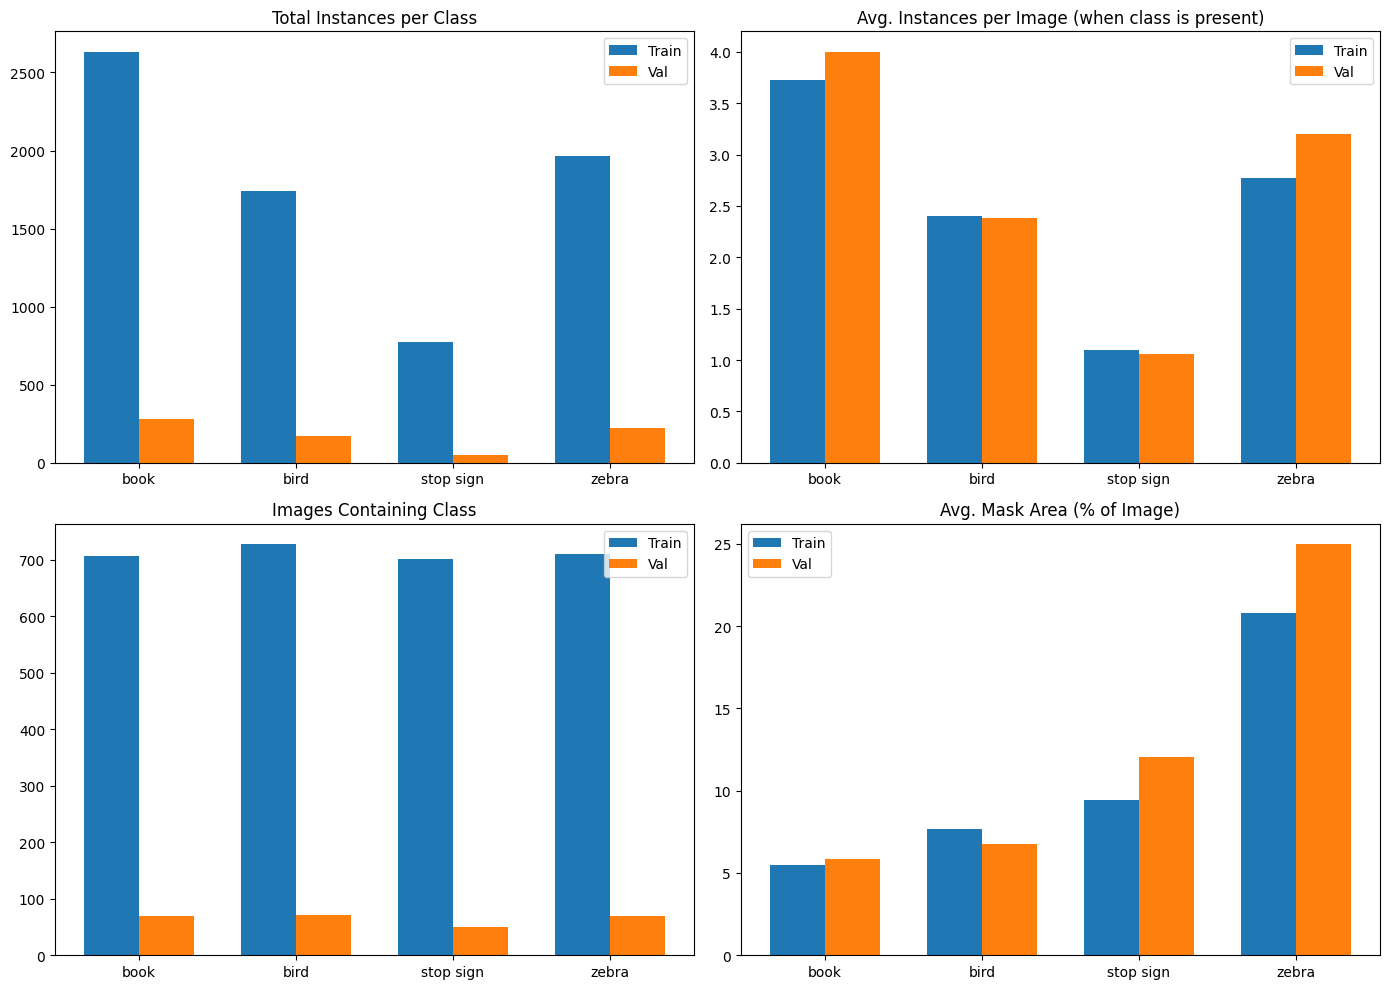


Statistics saved to dataset_statistics.json


In [11]:
# New cell for dataset statistics
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calculate_dataset_statistics(dataset_obj, split_name):
    """Calculate comprehensive statistics for a dataset"""
    print(f"\nAnalyzing {split_name} dataset statistics...")
    
    # Init counters
    total_images = len(dataset_obj.image_ids)
    total_instances = 0
    instances_per_class = {cat_id: 0 for cat_id in dataset_obj.categories_to_keep}
    
    # For mask area calculations
    total_mask_area_ratio = 0
    mask_area_ratio_per_class = {cat_id: 0 for cat_id in dataset_obj.categories_to_keep}
    
    # For images containing each class
    images_with_class = {cat_id: 0 for cat_id in dataset_obj.categories_to_keep}
    
    # Process each image
    for img_id in tqdm(dataset_obj.image_ids):
        # Get image dimensions
        img_info = dataset_obj.coco_seg.loadImgs(img_id)[0]
        img_area = img_info['width'] * img_info['height']
        
        # Get annotations for this image
        ann_ids = dataset_obj.coco_seg.getAnnIds(
            imgIds=img_id, 
            catIds=dataset_obj.categories_to_keep, 
            iscrowd=False
        )
        anns = dataset_obj.coco_seg.loadAnns(ann_ids)
        valid_anns = [ann for ann in anns if ann['area'] >= dataset_obj.min_area_threshold]
        
        # Count instances
        img_instances = len(valid_anns)
        total_instances += img_instances
        
        # Track mask area and classes in this image
        total_mask_area_for_image = 0
        classes_in_image = set()
        
        # Per annotation stats
        for ann in valid_anns:
            cat_id = ann['category_id']
            instances_per_class[cat_id] += 1
            classes_in_image.add(cat_id)
            
            # Calculate mask area ratio
            mask_area = ann['area']
            mask_ratio = mask_area / img_area
            
            total_mask_area_for_image += mask_area
            mask_area_ratio_per_class[cat_id] += mask_ratio
        
        # Update which images contain each class
        for cat_id in classes_in_image:
            images_with_class[cat_id] += 1
        
        # Calculate total mask ratio for this image
        if img_instances > 0:
            img_mask_ratio = total_mask_area_for_image / img_area
            total_mask_area_ratio += img_mask_ratio
    
    # Calculate averages
    avg_instances_per_image = total_instances / total_images if total_images > 0 else 0
    
    # Per-class averages
    avg_instances_per_class = {}
    for cat_id in dataset_obj.categories_to_keep:
        # Average per image that contains this class
        if images_with_class[cat_id] > 0:
            avg_instances_per_class[cat_id] = instances_per_class[cat_id] / images_with_class[cat_id]
        else:
            avg_instances_per_class[cat_id] = 0
    
    # Average mask area ratio across all images
    avg_mask_area_ratio = total_mask_area_ratio / total_images if total_images > 0 else 0
    
    # Per-class mask area ratios
    avg_mask_area_ratio_per_class = {}
    for cat_id in dataset_obj.categories_to_keep:
        if images_with_class[cat_id] > 0:
            avg_mask_area_ratio_per_class[cat_id] = mask_area_ratio_per_class[cat_id] / images_with_class[cat_id]
        else:
            avg_mask_area_ratio_per_class[cat_id] = 0
    
    # Compile results
    stats = {
        "total_images": total_images,
        "total_instances": total_instances,
        "avg_instances_per_image": avg_instances_per_image,
        "instances_per_class": instances_per_class,
        "avg_instances_per_class": avg_instances_per_class,
        "images_with_class": images_with_class,
        "avg_mask_area_ratio": avg_mask_area_ratio,
        "avg_mask_area_ratio_per_class": avg_mask_area_ratio_per_class
    }
    
    return stats

def display_statistics(stats, dataset_obj, split_name):
    """Format and print statistics in a readable way"""
    print(f"\n===== {split_name} Dataset Statistics =====")
    print(f"Total images: {stats['total_images']}")
    print(f"Total instances: {stats['total_instances']}")
    print(f"Average instances per image: {stats['avg_instances_per_image']:.2f}")
    
    print("\nDistribution by class:")
    for cat_id in dataset_obj.categories_to_keep:
        class_name = dataset_obj.category_map[cat_id]
        print(f"  {class_name} (ID: {cat_id}):")
        print(f"    - Total instances: {stats['instances_per_class'][cat_id]}")
        print(f"    - Images containing class: {stats['images_with_class'][cat_id]} ({stats['images_with_class'][cat_id]/stats['total_images']*100:.1f}%)")
        print(f"    - Avg. instances per image with this class: {stats['avg_instances_per_class'][cat_id]:.2f}")
    
    print(f"\nMask area statistics:")
    print(f"  Average mask area (% of image): {stats['avg_mask_area_ratio']*100:.2f}%")
    
    print("\nMask area per class (% of image):")
    for cat_id in dataset_obj.categories_to_keep:
        class_name = dataset_obj.category_map[cat_id]
        print(f"  {class_name}: {stats['avg_mask_area_ratio_per_class'][cat_id]*100:.2f}%")

def visualize_statistics(train_stats, val_stats, dataset_obj):
    """Create bar charts to visualize key statistics"""
    cat_names = [dataset_obj.category_map[cat_id] for cat_id in dataset_obj.categories_to_keep]
    
    # Setup figure with 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Instances per class
    train_instances = [train_stats['instances_per_class'][cat_id] for cat_id in dataset_obj.categories_to_keep]
    val_instances = [val_stats['instances_per_class'][cat_id] for cat_id in dataset_obj.categories_to_keep]
    
    x = np.arange(len(cat_names))
    width = 0.35
    
    axs[0, 0].bar(x - width/2, train_instances, width, label='Train')
    axs[0, 0].bar(x + width/2, val_instances, width, label='Val')
    axs[0, 0].set_title('Total Instances per Class')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(cat_names)
    axs[0, 0].legend()
    
    # Average instances per image per class
    train_avg = [train_stats['avg_instances_per_class'][cat_id] for cat_id in dataset_obj.categories_to_keep]
    val_avg = [val_stats['avg_instances_per_class'][cat_id] for cat_id in dataset_obj.categories_to_keep]
    
    axs[0, 1].bar(x - width/2, train_avg, width, label='Train')
    axs[0, 1].bar(x + width/2, val_avg, width, label='Val')
    axs[0, 1].set_title('Avg. Instances per Image (when class is present)')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(cat_names)
    axs[0, 1].legend()
    
    # Images containing each class
    train_imgs = [train_stats['images_with_class'][cat_id] for cat_id in dataset_obj.categories_to_keep]
    val_imgs = [val_stats['images_with_class'][cat_id] for cat_id in dataset_obj.categories_to_keep]
    
    axs[1, 0].bar(x - width/2, train_imgs, width, label='Train')
    axs[1, 0].bar(x + width/2, val_imgs, width, label='Val')
    axs[1, 0].set_title('Images Containing Class')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(cat_names)
    axs[1, 0].legend()
    
    # Average mask area per class
    train_mask = [train_stats['avg_mask_area_ratio_per_class'][cat_id]*100 for cat_id in dataset_obj.categories_to_keep]
    val_mask = [val_stats['avg_mask_area_ratio_per_class'][cat_id]*100 for cat_id in dataset_obj.categories_to_keep]
    
    axs[1, 1].bar(x - width/2, train_mask, width, label='Train')
    axs[1, 1].bar(x + width/2, val_mask, width, label='Val')
    axs[1, 1].set_title('Avg. Mask Area (% of Image)')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(cat_names)
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Calculate statistics
train_stats = calculate_dataset_statistics(dataset_train, "Training")
val_stats = calculate_dataset_statistics(dataset_val, "Validation")

# Display statistics
display_statistics(train_stats, dataset_train, "Training")
display_statistics(val_stats, dataset_val, "Validation")

# Visualize statistics
visualize_statistics(train_stats, val_stats, dataset_train)

# Save statistics to JSON for future reference
import json
statistics = {
    "train": train_stats,
    "val": val_stats,
    "class_names": {cat_id: dataset_train.category_map[cat_id] for cat_id in dataset_train.categories_to_keep}
}

# Handle non-serializable values (like numpy types)
def convert_to_serializable(obj):
    if isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

with open("dataset_statistics.json", "w") as f:
    json.dump(statistics, f, indent=4, default=convert_to_serializable)
print("\nStatistics saved to dataset_statistics.json")